In [ ]:
#from sage.all import *
import warnings
warnings.filterwarnings("ignore", message=".*Signature.*numpy.longdouble.*")
#da ni warningov


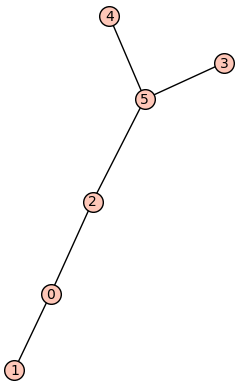

In [4]:
graphs.RandomTree(6).show()